In [1]:
import h5py
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
import shutil
import glob
import optparse
import os
import json
import pandas as pd
import numpy as np
import pylab as pl
import scipy.stats as stats
import seaborn as sns
sns.set_style("ticks")
sns.set()
sns.set_color_codes()

def findOccurrences(s, ch):
    return [i for i, letter in enumerate(s) if letter == ch]

def normalize_across_rows(in_array):

    min_val = np.min(in_array,0)
    max_val = np.max(in_array,0)

    min_mat = np.tile(min_val,(in_array.shape[0],1))
    max_mat = np.tile(max_val,(in_array.shape[0],1))
    range_mat = max_mat - min_mat

    out_array = np.true_divide(in_array-min_mat,range_mat)

    out_array[np.isnan(out_array)] = 0
    
    return out_array

def normalize_across_rows2(in_array):

    min_val = np.min(in_array,0)
    max_val = np.max(in_array,0)

    min_mat = np.tile(min_val,(in_array.shape[0],1))
    max_mat = np.tile(max_val,(in_array.shape[0],1))
    range_mat = max_mat - min_mat

    out_array = np.true_divide(in_array,max_mat)

    out_array[np.isnan(out_array)] = 0
    
    return out_array

def get_upper_triangle_values(in_array):
    mask = np.ones(in_array.shape)
    tmp = np.tril(mask,0)
    out_val = in_array[np.where(tmp==0)]
    
    return out_val

def shuffle_and_split_cells(response_array):
    ncells = response_array.shape[1]
    shuffled_cell_idxs = np.random.permutation(ncells)
    
    shuffled_half1 = shuffled_cell_idxs[0:ncells:2]
    shuffled_half2 = shuffled_cell_idxs[1:ncells:2]
    response_array_half1 = response_array[:,shuffled_half1]
    response_array_half2 = response_array[:,shuffled_half2]
    
    return response_array_half1, response_array_half2
def correlate_split_half_RDM(half1_array,half2_array):
    R_all_half1 = np.corrcoef(half1_array)
    R_all_half2 = np.corrcoef(half2_array)

    all_half1_values = get_upper_triangle_values(R_all_half1)
    all_half2_values = get_upper_triangle_values(R_all_half2)
    
    R = np.corrcoef(all_half1_values,all_half2_values)
    
    return R[0,1]
    

In [2]:


dset_list = ['V1_JC085_20190624','V1_JC085_20190712','V1_JC097_20190621','V1_JC097_20190628',\
             'V1_JC097_20190704',\
             'LM_JC080_20190619','LM_JC091_20190621','LM_JC091_20190703','LM_JC091_20190628',\
             'LM_JC097_20190702','LM_JC097_20190708',\
             'LI_JC091_20190625','LI_JC091_20190701','LI_JC091_20190705'
            ]


response_type = 'df_f'

#to figure out responsive cells
filter_crit = 'zscore'
filter_thresh = 1

#define paths
aggregate_root = '/n/coxfs01/cechavarria/2p-aggregate/scenes'
fig_base_dir = os.path.join(aggregate_root,'RSA_pooled','figures','thresh_%s_%i'%(filter_crit,filter_thresh))



if 'norm' in response_type:
    i1 = findOccurrences(response_type,'_')[-1]
    fetch_data = response_type[i1+1:]
else:
    fetch_data = response_type
print(fetch_data)


df_f


In [3]:
#get responses


area_list = ['V1','LM','LI']
animalid_list = []
sess_count = []
areaid = np.zeros((len(dset_list,)))
animalid = np.zeros((len(dset_list,)))
sessid = np.zeros((len(dset_list,)))

#consider all cells
V1_response_all = []
LM_response_all = []
LI_response_all = []

#consider only responsive cells
V1_response_active = []
LM_response_active = []
LI_response_active = []

#arrays for split-half data
#consider all cells
V1_response_all_half1 = []
LM_response_all_half1 = []
LI_response_all_half1 = []
V1_response_all_half2 = []
LM_response_all_half2 = []
LI_response_all_half2 = []

#consider only responsive cells
V1_response_active_half1 = []
LM_response_active_half1 = []
LI_response_active_half1 = []
V1_response_active_half2 = []
LM_response_active_half2 = []
LI_response_active_half2 = []



for dset_idx, dset in enumerate(dset_list):
    print(dset)
#     dset_idx = 0
#     dset = dset_list[dset_idx]

    #figure out some indexes
    i0 = findOccurrences(dset,'_')[0]
    i1 = findOccurrences(dset,'_')[1]

    area = dset[0:i0]
    animal = dset[i0+1:i1]
    session = dset[i1+1:]

    if animal not in animalid_list:
        animalid_list.append(animal)
        sess_count.append(0)

    sess_count[animalid_list.index(animal)] = sess_count[animalid_list.index(animal)]+1

    areaid[dset_idx] = area_list.index(area)
    animalid[dset_idx] = animalid_list.index(animal)
    sessid[dset_idx] = sess_count[animalid_list.index(animal)]-1


    #load data
    aggregate_file_dir = os.path.join(aggregate_root,area,'files','trial_responses')
    data_array_fn = '%s_%s_trial_response_array.hdf5'%(animal, session)
    data_array_filepath = os.path.join(aggregate_file_dir, data_array_fn)
    data_grp = h5py.File(data_array_filepath, 'r')

    cell_rois = data_grp.attrs['s2p_cell_rois']

    curr_slice = 'Slice01'#hard,coding for now

    #unpack
    response_matrix = np.array(data_grp['/'.join([curr_slice, 'responses' ,fetch_data])])

    filter_crit_matrix_trials = np.array(data_grp['/'.join([curr_slice, 'responses' ,filter_crit])])
    
    
    if filter_crit == 'zscore':
        filter_crit_matrix_trials = filter_crit_matrix_trials[:,:,cell_rois]
        filter_crit_matrix_mean = np.squeeze(np.mean(filter_crit_matrix_trials,0))
    elif filter_crit == 'simple_pval' or filter_crit == 'paired_pval' or filter_crit == 'perm_p' or 'stat' in filter_crit:
        filter_crit_matrix_mean = filter_crit_matrix_trials[:,cell_rois]
    elif filter_crit == 'split_half_R':
        filter_crit_matrix_mean = filter_crit_matrix_trials[cell_rois]
        
    #considering only cell rois
    response_matrix = response_matrix[:,:,cell_rois]
    ntrials,nconfigs,nrois = response_matrix.shape

    data_grp.close()

    #avg over trials
    mean_response_matrix = np.mean(response_matrix,0)
    #split data into half by selecting odd or even trials
    mean_response_matrix_half1 = np.mean(response_matrix[0:ntrials:2,:,:],0)
    mean_response_matrix_half2 = np.mean(response_matrix[1:ntrials:2,:,:],0)

    #consider a config active if at least one of theversion of an image evoked a response above threshol
    
    if filter_crit == 'zscore' or 'tstat' in filter_crit:
        thresh = filter_thresh
        thresh_matrix = filter_crit_matrix_mean>thresh
    elif filter_crit == 'simple_pval' or filter_crit == 'paired_pval' or filter_crit == 'perm_p':
        thresh = filter_thresh
        thresh_matrix = np.logical_and(filter_crit_matrix_mean<thresh,filter_crit_matrix_mean>0)
    elif filter_crit == 'split_half_R':
        thresh = filter_thresh
        thresh_matrix= filter_crit_matrix_mean>thresh
        thresh_matrix = np.expand_dims(thresh_matrix,0)
        thresh_matrix = np.tile(thresh_matrix,(nconfigs,1))

    filter_matrix = np.ones((thresh_matrix.shape))*np.nan
    active_rois_per_config = np.nansum(thresh_matrix,1)
    for ridx in range(nrois):
        for idx in range(0,thresh_matrix.shape[0],3):
                if np.sum(thresh_matrix[idx:idx+3,ridx])>0:
                    filter_matrix[idx:idx+3,ridx] = 1

    #figure out some activity details
    active_cell_idx = np.nansum(filter_matrix,0)>0
    num_active_rois = np.nansum(np.nansum(filter_matrix,0)>0)
    frac_active_rois = num_active_rois/float(len(cell_rois))
    print('# active rois = %i'%(num_active_rois))
    print('frac active rois = %.04f'%(frac_active_rois))

    #normalize across configs within cell, if necessary
    if 'norm' in response_type:
        norm_response_array = np.empty((nconfigs,nrois))

        for ridx in range(nrois):
            norm_response_array[:,ridx] = mean_response_matrix[:,ridx]/np.nanmax(mean_response_matrix[:,ridx])
        mean_response_matrix = norm_response_array


    #store average responses in array
    dset_response = mean_response_matrix
    dset_response_active = mean_response_matrix[:,active_cell_idx]
    dset_response_half1 = mean_response_matrix_half1
    dset_response_active_half1 = mean_response_matrix_half1[:,active_cell_idx]
    dset_response_half2 = mean_response_matrix_half2
    dset_response_active_half2 = mean_response_matrix_half2[:,active_cell_idx]



    if area == 'V1':
        if len(V1_response_active)==0:
            V1_response_active = dset_response_active
            V1_response_all = dset_response
            V1_response_active_half1 = dset_response_active_half1
            V1_response_all_half1 = dset_response_half1
            V1_response_active_half2 = dset_response_active_half2
            V1_response_all_half2 = dset_response_half2
        else:
            V1_response_active = np.hstack((V1_response_active, dset_response_active))
            V1_response_all = np.hstack((V1_response_all, dset_response))
            V1_response_active_half1 = np.hstack((V1_response_active_half1, dset_response_active_half1))
            V1_response_all_half1 = np.hstack((V1_response_all_half1, dset_response_half1))
            V1_response_active_half2 = np.hstack((V1_response_active_half2, dset_response_active_half2))
            V1_response_all_half2 = np.hstack((V1_response_all_half2, dset_response_half2))
    elif area == 'LM':
        if len(LM_response_active)==0:
            LM_response_active = dset_response_active
            LM_response_all = dset_response
            LM_response_active_half1 = dset_response_active_half1
            LM_response_all_half1 = dset_response_half1
            LM_response_active_half2 = dset_response_active_half2
            LM_response_all_half2 = dset_response_half2
        else:
            LM_response_active = np.hstack((LM_response_active, dset_response_active))
            LM_response_all = np.hstack((LM_response_all, dset_response))
            LM_response_active_half1 = np.hstack((LM_response_active_half1, dset_response_active_half1))
            LM_response_all_half1 = np.hstack((LM_response_all_half1, dset_response_half1))
            LM_response_active_half2 = np.hstack((LM_response_active_half2, dset_response_active_half2))
            LM_response_all_half2 = np.hstack((LM_response_all_half2, dset_response_half2))
    elif area == 'LI':
        if len(LI_response_active)==0:
            LI_response_active = dset_response_active
            LI_response_all = dset_response
            LI_response_active_half1 = dset_response_active_half1
            LI_response_all_half1 = dset_response_half1
            LI_response_active_half2 = dset_response_active_half2
            LI_response_all_half2 = dset_response_half2
        else:
            LI_response_active = np.hstack((LI_response_active, dset_response_active))
            LI_response_all = np.hstack((LI_response_all, dset_response))
            LI_response_active_half1 = np.hstack((LI_response_active_half1, dset_response_active_half1))
            LI_response_all_half1 = np.hstack((LI_response_all_half1, dset_response_half1))
            LI_response_active_half2 = np.hstack((LI_response_active_half2, dset_response_active_half2))
            LI_response_all_half2 = np.hstack((LI_response_all_half2, dset_response_half2))

V1_JC085_20190624
# active rois = 13
frac active rois = 0.0935
V1_JC085_20190712
# active rois = 14
frac active rois = 0.1129
V1_JC097_20190621
# active rois = 18
frac active rois = 0.1333
V1_JC097_20190628
# active rois = 22
frac active rois = 0.1583
V1_JC097_20190704
# active rois = 22
frac active rois = 0.1849
LM_JC080_20190619
# active rois = 7
frac active rois = 0.0449
LM_JC091_20190621
# active rois = 11
frac active rois = 0.0815
LM_JC091_20190703
# active rois = 11
frac active rois = 0.0821
LM_JC091_20190628
# active rois = 7
frac active rois = 0.0667
LM_JC097_20190702
# active rois = 12
frac active rois = 0.0896
LM_JC097_20190708
# active rois = 10
frac active rois = 0.0909
LI_JC091_20190625
# active rois = 22
frac active rois = 0.1477
LI_JC091_20190701
# active rois = 1
frac active rois = 0.0077
LI_JC091_20190705
# active rois = 9
frac active rois = 0.0968


In [4]:
#replace nans with 0's (found a single unit with a flat timecourse...weird but doesn't seem to be issue in post-2p handling of data)
V1_response_active[np.isnan(V1_response_active)] = 0
V1_response_all[np.isnan(V1_response_all)] = 0
V1_response_active_half1[np.isnan(V1_response_active_half1)] = 0
V1_response_all_half1[np.isnan(V1_response_all_half1)] = 0
V1_response_active_half2[np.isnan(V1_response_active_half2)] = 0
V1_response_all_half2[np.isnan(V1_response_all_half2)] = 0

LM_response_active[np.isnan(LM_response_active)] = 0
LM_response_all[np.isnan(LM_response_all)] = 0
LM_response_active_half1[np.isnan(LM_response_active_half1)] = 0
LM_response_all_half1[np.isnan(LM_response_all_half1)] = 0
LM_response_active_half2[np.isnan(LM_response_active_half2)] = 0
LM_response_all_half2[np.isnan(LM_response_all_half2)] = 0

LI_response_active[np.isnan(LI_response_active)] = 0
LI_response_all[np.isnan(LI_response_all)] = 0
LI_response_active_half1[np.isnan(LI_response_active_half1)] = 0
LI_response_all_half1[np.isnan(LI_response_all_half1)] = 0
LI_response_active_half2[np.isnan(LI_response_active_half2)] = 0
LI_response_all_half2[np.isnan(LI_response_all_half2)] = 0

#zscore data across configs
V1_response_all_zscore = stats.zscore(V1_response_all,0)
V1_response_active_zscore = stats.zscore(V1_response_active,0)
V1_response_all_half1_zscore = stats.zscore(V1_response_all_half1,0)
V1_response_active_half1_zscore = stats.zscore(V1_response_active_half1,0)
V1_response_all_half2_zscore = stats.zscore(V1_response_all_half2,0)
V1_response_active_half2_zscore = stats.zscore(V1_response_active_half2,0)

LM_response_all_zscore = stats.zscore(LM_response_all,0)
LM_response_active_zscore = stats.zscore(LM_response_active,0)
LM_response_all_half1_zscore = stats.zscore(LM_response_all_half1,0)
LM_response_active_half1_zscore = stats.zscore(LM_response_active_half1,0)
LM_response_all_half2_zscore = stats.zscore(LM_response_all_half2,0)
LM_response_active_half2_zscore = stats.zscore(LM_response_active_half2,0)

LI_response_all_zscore = stats.zscore(LI_response_all,0)
LI_response_active_zscore = stats.zscore(LI_response_active,0)
LI_response_all_half1_zscore = stats.zscore(LI_response_all_half1,0)
LI_response_active_half1_zscore = stats.zscore(LI_response_active_half1,0)
LI_response_all_half2_zscore = stats.zscore(LI_response_all_half2,0)
LI_response_active_half2_zscore = stats.zscore(LI_response_active_half2,0)


#replace nans with 0's
V1_response_all_zscore[np.isnan(V1_response_all_zscore)] = 0
V1_response_active_zscore[np.isnan(V1_response_active_zscore)] = 0
V1_response_all_half1_zscore[np.isnan(V1_response_all_half1_zscore)] = 0
V1_response_active_half1_zscore[np.isnan(V1_response_active_half1_zscore)] = 0
V1_response_all_half2_zscore[np.isnan(V1_response_all_half2_zscore)] = 0
V1_response_active_half2_zscore[np.isnan(V1_response_active_half2_zscore)] = 0

LM_response_all_zscore[np.isnan(LM_response_all_zscore)] = 0
LM_response_active_zscore[np.isnan(LM_response_active_zscore)] = 0
LM_response_all_half1_zscore[np.isnan(LM_response_all_half1_zscore)] = 0
LM_response_active_half1_zscore[np.isnan(LM_response_active_half1_zscore)] = 0
LM_response_all_half2_zscore[np.isnan(LM_response_all_half2_zscore)] = 0
LM_response_active_half2_zscore[np.isnan(LM_response_active_half2_zscore)] = 0

LI_response_all_zscore[np.isnan(LI_response_all_zscore)] = 0
LI_response_active_zscore[np.isnan(LI_response_active_zscore)] = 0

LI_response_all_half1_zscore[np.isnan(LI_response_all_half1_zscore)] = 0
LI_response_all_half1_zscore[np.isnan(LI_response_all_half1_zscore)] = 0

LI_response_all_half2_zscore[np.isnan(LI_response_all_half2_zscore)] = 0
LI_response_all_half2_zscore[np.isnan(LI_response_all_half2_zscore)] = 0

In [5]:
selfR_V1_all_zscore = np.empty((nconfigs,))
selfR_V1_active_zscore = np.empty((nconfigs,)) 

selfR_LM_all_zscore = np.empty((nconfigs,)) 
selfR_LM_active_zscore = np.empty((nconfigs,)) 

selfR_LI_all_zscore = np.empty((nconfigs,)) 
selfR_LI_active_zscore = np.empty((nconfigs,)) 

#check correlation between data-halves within each configuration
for cfg_idx in range(nconfigs):
    R_mat_V1_all = np.corrcoef(V1_response_all_half1_zscore[cfg_idx,:],V1_response_all_half2_zscore[cfg_idx,:])
    R_mat_V1_active = np.corrcoef(V1_response_active_half1_zscore[cfg_idx,:],V1_response_active_half2_zscore[cfg_idx,:])

    R_mat_LM_all = np.corrcoef(LM_response_all_half1_zscore[cfg_idx,:],LM_response_all_half2_zscore[cfg_idx,:])
    R_mat_LM_active = np.corrcoef(LM_response_active_half1_zscore[cfg_idx,:],LM_response_active_half2_zscore[cfg_idx,:])

    R_mat_LI_all = np.corrcoef(LI_response_all_half1_zscore[cfg_idx,:],LI_response_all_half2_zscore[cfg_idx,:])
    R_mat_LI_active = np.corrcoef(LI_response_active_half1_zscore[cfg_idx,:],LI_response_active_half2_zscore[cfg_idx,:])

    selfR_V1_all_zscore[cfg_idx] = R_mat_V1_all[0,1]
    selfR_V1_active_zscore[cfg_idx] = R_mat_V1_active[0,1]

    selfR_LM_all_zscore[cfg_idx] = R_mat_LM_all[0,1]
    selfR_LM_active_zscore[cfg_idx] = R_mat_LM_active[0,1]

    selfR_LI_all_zscore[cfg_idx] = R_mat_LI_all[0,1]
    selfR_LI_active_zscore[cfg_idx] = R_mat_LI_active[0,1]

#get correlations
R_V1_all_zscore = np.corrcoef(V1_response_all_zscore)
R_V1_active_zscore = np.corrcoef(V1_response_active_zscore)

R_LM_all_zscore = np.corrcoef(LM_response_all_zscore)
R_LM_active_zscore = np.corrcoef(LM_response_active_zscore)

R_LI_all_zscore = np.corrcoef(LI_response_all_zscore)
R_LI_active_zscore = np.corrcoef(LI_response_active_zscore)

#replace diagional values
for cfg_idx in range(nconfigs):
    R_V1_all_zscore[cfg_idx,cfg_idx] = selfR_V1_all_zscore[cfg_idx]
    R_V1_active_zscore[cfg_idx,cfg_idx] = selfR_V1_active_zscore[cfg_idx]
    
    R_LM_all_zscore[cfg_idx,cfg_idx] = selfR_LM_all_zscore[cfg_idx]
    R_LM_active_zscore[cfg_idx,cfg_idx] = selfR_LM_active_zscore[cfg_idx]
    
    R_LI_all_zscore[cfg_idx,cfg_idx] = selfR_LI_all_zscore[cfg_idx]
    R_LI_active_zscore[cfg_idx,cfg_idx] = selfR_LI_active_zscore[cfg_idx]

#plot individual area correlation matrices
fig_out_dir = os.path.join(fig_base_dir,'zscore_%s'%response_type)
if not os.path.isdir(fig_out_dir):
        os.makedirs(fig_out_dir)

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_V1_all_zscore,center = 0,annot=False, cmap = 'RdBu_r',vmin = -1, vmax = 1)


ax.set_yticks(np.arange(1,61,3))
ax.set_yticklabels(np.arange(1,21).tolist())
ax.set_xticks(np.arange(1,61,3))
ax.set_xticklabels(np.arange(1,21).tolist())

fig_name = 'all_V1_zscore_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_V1_active_zscore,center = 0,annot=False, cmap = 'RdBu_r',vmin = -1, vmax = 1)

ax.set_yticks(np.arange(1,61,3))
ax.set_yticklabels(np.arange(1,21).tolist())
ax.set_xticks(np.arange(1,61,3))
ax.set_xticklabels(np.arange(1,21).tolist())

fig_name = 'active_V1_zscore_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_LM_all_zscore,center = 0,annot=False, cmap = 'RdBu_r',vmin = -1, vmax = 1)

ax.set_yticks(np.arange(1,61,3))
ax.set_yticklabels(np.arange(1,21).tolist())
ax.set_xticks(np.arange(1,61,3))
ax.set_xticklabels(np.arange(1,21).tolist())

fig_name = 'all_LM_zscore_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_LM_active_zscore,center = 0,annot=False, cmap = 'RdBu_r',vmin = -1, vmax = 1)

ax.set_yticks(np.arange(1,61,3))
ax.set_yticklabels(np.arange(1,21).tolist())
ax.set_xticks(np.arange(1,61,3))
ax.set_xticklabels(np.arange(1,21).tolist())

fig_name = 'active_LM_zscore_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_LI_all_zscore,center = 0,annot=False, cmap = 'RdBu_r',vmin = -1, vmax = 1)

ax.set_yticks(np.arange(1,61,3))
ax.set_yticklabels(np.arange(1,21).tolist())
ax.set_xticks(np.arange(1,61,3))
ax.set_xticklabels(np.arange(1,21).tolist())

fig_name = 'all_LI_zscore_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_LI_active_zscore,center = 0,annot=False, cmap = 'RdBu_r',vmin = -1, vmax = 1)

ax.set_yticks(np.arange(1,61,3))
ax.set_yticklabels(np.arange(1,21).tolist())
ax.set_xticks(np.arange(1,61,3))
ax.set_xticklabels(np.arange(1,21).tolist())

fig_name = 'active_LI_zscore_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

In [6]:
#get within_area correlation values
nreps = 100

Rself_V1_all_array = np.empty((nreps,))
Rself_V1_active_array = np.empty((nreps,))

Rself_LM_all_array = np.empty((nreps,))
Rself_LM_active_array = np.empty((nreps,))

Rself_LI_all_array = np.empty((nreps,))
Rself_LI_active_array = np.empty((nreps,))


for rep in range(nreps):

    V1_all_zscore_half1, V1_all_zscore_half2 = shuffle_and_split_cells(V1_response_all_zscore)
    V1_active_zscore_half1, V1_active_zscore_half2 = shuffle_and_split_cells(V1_response_active_zscore)

    LM_all_zscore_half1, LM_all_zscore_half2 = shuffle_and_split_cells(LM_response_all_zscore)
    LM_active_zscore_half1, LM_active_zscore_half2 = shuffle_and_split_cells(LM_response_active_zscore)

    LI_all_zscore_half1, LI_all_zscore_half2 = shuffle_and_split_cells(LI_response_all_zscore)
    LI_active_zscore_half1, LI_active_zscore_half2 = shuffle_and_split_cells(LI_response_active_zscore)



    Rself_V1_all_array[rep] = correlate_split_half_RDM(V1_all_zscore_half1,V1_all_zscore_half2)
    Rself_V1_active_array[rep] = correlate_split_half_RDM(V1_active_zscore_half1,V1_active_zscore_half2)

    Rself_LM_all_array[rep] = correlate_split_half_RDM(LM_all_zscore_half1,LM_all_zscore_half2)
    Rself_LM_active_array[rep] = correlate_split_half_RDM(LM_active_zscore_half1,LM_active_zscore_half2)

    Rself_LI_all_array[rep] = correlate_split_half_RDM(LI_all_zscore_half1,LI_all_zscore_half2)
    Rself_LI_active_array[rep] = correlate_split_half_RDM(LI_active_zscore_half1,LI_active_zscore_half2)



    Rself_V1_all_array[rep] = correlate_split_half_RDM(V1_all_zscore_half1,V1_all_zscore_half2)
    Rself_V1_active_array[rep] = correlate_split_half_RDM(V1_active_zscore_half1,V1_active_zscore_half2)

    Rself_LM_all_array[rep] = correlate_split_half_RDM(LM_all_zscore_half1,LM_all_zscore_half2)
    Rself_LM_active_array[rep] = correlate_split_half_RDM(LM_active_zscore_half1,LM_active_zscore_half2)

    Rself_LI_all_array[rep] = correlate_split_half_RDM(LI_all_zscore_half1,LI_all_zscore_half2)
    Rself_LI_active_array[rep] = correlate_split_half_RDM(LI_active_zscore_half1,LI_active_zscore_half2)

Rself_V1_all_zscore = np.mean(Rself_V1_all_array)
Rself_V1_active_zscore = np.mean(Rself_V1_active_array)
Rself_LM_all_zscore = np.mean(Rself_LM_all_array)
Rself_LM_active_zscore = np.mean(Rself_LM_active_array)
Rself_LI_all_zscore = np.mean(Rself_LI_all_array)
Rself_LI_active_zscore = np.mean(Rself_LI_active_array)

In [7]:
#get cross-area correlation values
R_V1_all_zscore_val = get_upper_triangle_values(R_V1_all_zscore)
R_LM_all_zscore_val = get_upper_triangle_values(R_LM_all_zscore)
R_LI_all_zscore_val = get_upper_triangle_values(R_LI_all_zscore)

R_V1_active_zscore_val = get_upper_triangle_values(R_V1_active_zscore)
R_LM_active_zscore_val = get_upper_triangle_values(R_LM_active_zscore)
R_LI_active_zscore_val = get_upper_triangle_values(R_LI_active_zscore)

R_all_areas_zscore = np.vstack((R_V1_all_zscore_val, R_LM_all_zscore_val, R_LI_all_zscore_val))
R_across_areas_all_zscore = np.corrcoef(R_all_areas_zscore)

R_active_areas_zscore = np.vstack((R_V1_active_zscore_val, R_LM_active_zscore_val, R_LI_active_zscore_val))
R_across_areas_active_zscore = np.corrcoef(R_active_areas_zscore)


In [8]:
#replace diagnonal
R_across_areas_all_zscore[0,0] = Rself_V1_all_zscore
R_across_areas_active_zscore[0,0] = Rself_V1_active_zscore
R_across_areas_all_zscore[1,1] = Rself_LM_all_zscore
R_across_areas_active_zscore[1,1] = Rself_LM_active_zscore
R_across_areas_all_zscore[2,2] = Rself_LI_all_zscore
R_across_areas_active_zscore[2,2] = Rself_LI_active_zscore


#plot cross-area correlations
plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_across_areas_all_zscore,center = 0,yticklabels = area_list,xticklabels = area_list,\
                 annot=True, cmap = 'RdBu_r',vmin = -1,vmax = 1)

fig_name = 'across_areas_all_zscore_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_across_areas_active_zscore,center = 0,yticklabels = area_list,xticklabels = area_list,\
                 annot=True, cmap = 'RdBu_r',vmin = -1, vmax = 1)

fig_name = 'across_areas_active_zscore_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

In [9]:
#get within_area correlation values - from half trials
Rself_trials_V1_all_zscore = correlate_split_half_RDM(V1_response_all_half1_zscore,V1_response_all_half2_zscore)
Rself_trials_V1_active_zscore = correlate_split_half_RDM(V1_response_active_half1_zscore,V1_response_active_half2_zscore)

Rself_trials_LM_all_zscore = correlate_split_half_RDM(LM_response_all_half1_zscore,LM_response_all_half2_zscore)
Rself_trials_LM_active_zscore = correlate_split_half_RDM(LM_response_active_half1_zscore,LM_response_active_half2_zscore)

Rself_trials_LI_all_zscore = correlate_split_half_RDM(LI_response_all_half1_zscore,LI_response_all_half2_zscore)
Rself_trials_LI_active_zscore = correlate_split_half_RDM(LI_response_active_half1_zscore,LI_response_active_half2_zscore)

In [10]:
#replace diagnonal
R_across_areas_all_zscore[0,0] = Rself_trials_V1_all_zscore
R_across_areas_active_zscore[0,0] = Rself_trials_V1_active_zscore
R_across_areas_all_zscore[1,1] = Rself_trials_LM_all_zscore
R_across_areas_active_zscore[1,1] = Rself_trials_LM_active_zscore
R_across_areas_all_zscore[2,2] = Rself_trials_LI_all_zscore
R_across_areas_active_zscore[2,2] = Rself_trials_LI_active_zscore


#plot cross-area correlations
plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_across_areas_all_zscore,center = 0,yticklabels = area_list,xticklabels = area_list,\
                 annot=True, cmap = 'RdBu_r',vmin = -1,vmax = 1)

fig_name = 'across_areas_all_zscore_pool_%s_RSA_trialR_diag.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_across_areas_active_zscore,center = 0,yticklabels = area_list,xticklabels = area_list,\
                 annot=True, cmap = 'RdBu_r',vmin = -1, vmax = 1)

fig_name = 'across_areas_active_zscore_pool_%s_RSA_trialR_diag.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

In [11]:

V1_all_zscore_half1, V1_all_zscore_half2 = shuffle_and_split_cells(V1_response_all_zscore)
V1_active_zscore_half1, V1_active_zscore_half2 = shuffle_and_split_cells(V1_response_active_zscore)

LM_all_zscore_half1, LM_all_zscore_half2 = shuffle_and_split_cells(LM_response_all_zscore)
LM_active_zscore_half1, LM_active_zscore_half2 = shuffle_and_split_cells(LM_response_active_zscore)

LI_all_zscore_half1, LI_all_zscore_half2 = shuffle_and_split_cells(LI_response_all_zscore)
LI_active_zscore_half1, LI_active_zscore_half2 = shuffle_and_split_cells(LI_response_active_zscore)


nreps = 100

Rself_V1_all_array = np.empty((nreps,))
Rself_V1_active_array = np.empty((nreps,))

Rself_LM_all_array = np.empty((nreps,))
Rself_LM_active_array = np.empty((nreps,))

Rself_LI_all_array = np.empty((nreps,))
Rself_LI_active_array = np.empty((nreps,))


for rep in range(nreps):
    Rself_V1_all_array[rep] = correlate_split_half_RDM(V1_all_zscore_half1,V1_all_zscore_half2)
    Rself_V1_active_array[rep] = correlate_split_half_RDM(V1_active_zscore_half1,V1_active_zscore_half2)

    Rself_LM_all_array[rep] = correlate_split_half_RDM(LM_all_zscore_half1,LM_all_zscore_half2)
    Rself_LM_active_array[rep] = correlate_split_half_RDM(LM_active_zscore_half1,LM_active_zscore_half2)

    Rself_LI_all_array[rep] = correlate_split_half_RDM(LI_all_zscore_half1,LI_all_zscore_half2)
    Rself_LI_active_array[rep] = correlate_split_half_RDM(LI_active_zscore_half1,LI_active_zscore_half2)



    Rself_V1_all_array[rep] = correlate_split_half_RDM(V1_all_zscore_half1,V1_all_zscore_half2)
    Rself_V1_active_array[rep] = correlate_split_half_RDM(V1_active_zscore_half1,V1_active_zscore_half2)

    Rself_LM_all_array[rep] = correlate_split_half_RDM(LM_all_zscore_half1,LM_all_zscore_half2)
    Rself_LM_active_array[rep] = correlate_split_half_RDM(LM_active_zscore_half1,LM_active_zscore_half2)

    Rself_LI_all_array[rep] = correlate_split_half_RDM(LI_all_zscore_half1,LI_all_zscore_half2)
    Rself_LI_active_array[rep] = correlate_split_half_RDM(LI_active_zscore_half1,LI_active_zscore_half2)

Rself_V1_all_zscore = np.mean(Rself_V1_all_array)
Rself_V1_active_zscore = np.mean(Rself_V1_active_array)
Rself_LM_all_zscore = np.mean(Rself_LM_all_array)
Rself_LM_active_zscore = np.mean(Rself_LM_active_array)
Rself_LI_all_zscore = np.mean(Rself_LI_all_array)
Rself_LI_active_zscore = np.mean(Rself_LI_active_array)

In [103]:
unitR_V1_active_zscore

array([[ 1.        ,  0.26447976,  0.44084929, ..., -0.27295442,
         0.02835845, -0.14028735],
       [ 0.26447976,  1.        ,  0.39534861, ..., -0.06928235,
         0.03807796, -0.05421146],
       [ 0.44084929,  0.39534861,  1.        , ..., -0.0719586 ,
         0.3535687 ,  0.06811602],
       ...,
       [-0.27295442, -0.06928235, -0.0719586 , ...,  1.        ,
         0.37568533,  0.64914564],
       [ 0.02835845,  0.03807796,  0.3535687 , ...,  0.37568533,
         1.        ,  0.43074318],
       [-0.14028735, -0.05421146,  0.06811602, ...,  0.64914564,
         0.43074318,  1.        ]])

In [12]:
all_active_cells = np.hstack((V1_response_active_zscore,LM_response_active_zscore,LI_response_active_zscore))

In [13]:
all_active_cells.shape

(60, 179)

In [14]:
unitR_all_active_zscore = np.corrcoef(np.transpose(all_active_cells))

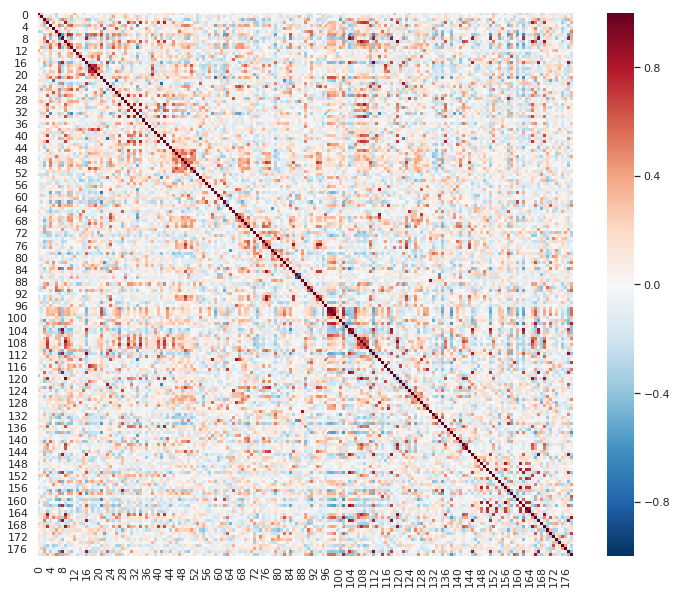

In [15]:

plt.figure(figsize=(12, 10))
ax = sns.heatmap(unitR_all_active_zscore,center = 0,annot=False, cmap = 'RdBu_r',vmin = -1, vmax = 1)

fig_name = '%s_all_active_unit_zscore_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
#plt.close()

In [151]:
unitR_all_active_zscore.shape

(626, 626)

In [16]:
V1_ncells = V1_response_active_zscore.shape[1]
LM_ncells = LM_response_active_zscore.shape[1]
LI_ncells = LI_response_active_zscore.shape[1]

In [17]:
print(V1_ncells,LM_ncells,LI_ncells)

89 58 32


In [18]:
from sklearn.manifold import MDS

In [19]:
embedding = MDS(n_components=2,dissimilarity = 'precomputed')
X_transformed = embedding.fit_transform(1 - unitR_all_active_zscore)
X_transformed.shape

(179, 2)

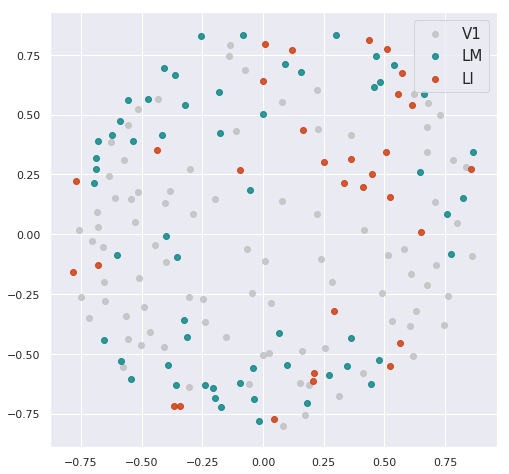

In [20]:
plt.figure(figsize=(8, 8))

idx0 = 0
idx1 = V1_ncells
plt.scatter(X_transformed[idx0:idx1,0],X_transformed[idx0:idx1,1],color = (.75,.75,.75),alpha = 0.8,label='V1')
idx0 = V1_ncells
idx1 = V1_ncells+LM_ncells
plt.scatter(X_transformed[idx0:idx1,0],X_transformed[idx0:idx1,1],color = (0,.5,.5),alpha = 0.8,label = 'LM')
idx0 = V1_ncells+LM_ncells
idx1 = -1
plt.scatter(X_transformed[idx0:idx1,0],X_transformed[idx0:idx1,1],color = (.8,.2,0),alpha = 0.8,label = 'LI')

plt.legend(fontsize = 15)

fig_name = '%s_all_active_unit_zscore_MDS.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)


plt.savefig(fig_fn) 
#plt.close()

In [21]:
from sklearn.manifold import TSNE

In [22]:
unitR_all_active_zscore.shape

(179, 179)

In [23]:
all_active_cells.shape

(60, 179)

In [24]:
unit_tsne = TSNE(n_components=2,perplexity = 50).fit_transform(np.transpose(all_active_cells))
unit_tsne.shape

(179, 2)

In [25]:
V1_ncells

89

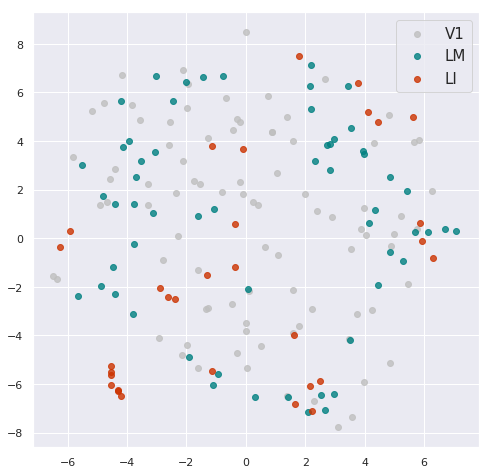

In [26]:
plt.figure(figsize=(8, 8))

idx0 = 0
idx1 = V1_ncells
plt.scatter(unit_tsne[idx0:idx1,0],unit_tsne[idx0:idx1,1],color = (.75,.75,.75),alpha = 0.8,label='V1')
idx0 = V1_ncells
idx1 = V1_ncells+LM_ncells
plt.scatter(unit_tsne[idx0:idx1,0],unit_tsne[idx0:idx1,1],color = (0,.5,.5),alpha = 0.8,label = 'LM')
idx0 = V1_ncells+LM_ncells
idx1 = -1
plt.scatter(unit_tsne[idx0:idx1,0],unit_tsne[idx0:idx1,1],color = (.8,.2,0),alpha = 0.8,label = 'LI')

plt.legend(fontsize = 15)

fig_name = '%s_all_active_unit_zscore_tsne.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)


plt.savefig(fig_fn) 
#plt.close()

In [ ]:
#compare correlation matrices across areas
R_V1_all_zscore_val = get_upper_triangle_values(R_V1_all_zscore)
R_LM_all_zscore_val = get_upper_triangle_values(R_LM_all_zscore)
R_LI_all_zscore_val = get_upper_triangle_values(R_LI_all_zscore)

R_V1_active_zscore_val = get_upper_triangle_values(R_V1_active_zscore)
R_LM_active_zscore_val = get_upper_triangle_values(R_LM_active_zscore)
R_LI_active_zscore_val = get_upper_triangle_values(R_LI_active_zscore)

R_all_areas_zscore = np.vstack((R_V1_all_zscore_val, R_LM_all_zscore_val, R_LI_all_zscore_val))
R_across_areas_all_zscore = np.corrcoef(R_all_areas_zscore)

R_active_areas_zscore = np.vstack((R_V1_active_zscore_val, R_LM_active_zscore_val, R_LI_active_zscore_val))
R_across_areas_active_zscore = np.corrcoef(R_active_areas_zscore)


#plot cross-area correlations
plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_across_areas_all_zscore,center = 0,yticklabels = area_list,xticklabels = area_list,\
                 annot=True, cmap = 'RdBu_r')

fig_name = 'across_areas_all_zscore_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_across_areas_active_zscore,center = 0,yticklabels = area_list,xticklabels = area_list,\
                 annot=True, cmap = 'RdBu_r')

fig_name = 'across_areas_active_zscore_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

In [262]:
#re-arrange by stimulus class
V1_response_all_class = np.vstack((V1_response_all[0:60:3,:],V1_response_all[1:60:3,:],V1_response_all[2:60:3,:]))
V1_response_active_class = np.vstack((V1_response_active[0:60:3,:],V1_response_active[1:60:3,:],V1_response_active[2:60:3,:]))


LM_response_all_class = np.vstack((LM_response_all[0:60:3,:],LM_response_all[1:60:3,:],LM_response_all[2:60:3,:]))
LM_response_active_class = np.vstack((LM_response_active[0:60:3,:],LM_response_active[1:60:3,:],LM_response_active[2:60:3,:]))


LI_response_all_class = np.vstack((LI_response_all[0:60:3,:],LI_response_all[1:60:3,:],LI_response_all[2:60:3,:]))
LI_response_active_class = np.vstack((LI_response_active[0:60:3,:],LI_response_active[1:60:3,:],LI_response_active[2:60:3,:]))




#zscore data across configs for re-arranged matrices
V1_response_all_class_zscore = stats.zscore(V1_response_all_class,0)
V1_response_active_class_zscore = stats.zscore(V1_response_active_class,0)

LM_response_all_class_zscore = stats.zscore(LM_response_all_class,0)
LM_response_active_class_zscore = stats.zscore(LM_response_active_class,0)

LI_response_all_class_zscore = stats.zscore(LI_response_all_class,0)
LI_response_active_class_zscore = stats.zscore(LI_response_active_class,0)



#replace nans with 0's
V1_response_all_class_zscore[np.isnan(V1_response_all_class_zscore)] = 0
V1_response_active_class_zscore[np.isnan(V1_response_active_class_zscore)] = 0

LM_response_all_class_zscore[np.isnan(LM_response_all_class_zscore)] = 0
LM_response_active_class_zscore[np.isnan(LM_response_active_class_zscore)] = 0

LI_response_all_class_zscore[np.isnan(LI_response_all_class_zscore)] = 0
LI_response_active_class_zscore[np.isnan(LI_response_active_class_zscore)] = 0

In [263]:
#get correlations
R_V1_all_class_zscore = np.corrcoef(V1_response_all_class_zscore)
R_V1_active_class_zscore = np.corrcoef(V1_response_active_class_zscore)

R_LM_all_class_zscore = np.corrcoef(LM_response_all_class_zscore)
R_LM_active_class_zscore = np.corrcoef(LM_response_active_class_zscore)

R_LI_all_class_zscore = np.corrcoef(LI_response_all_class_zscore)
R_LI_active_class_zscore = np.corrcoef(LI_response_active_class_zscore)

In [232]:
R_V1_all_zscore[32,:]

array([ 0.36251261,  0.20487786, -0.30700712, -0.03632418, -0.09434715,
        0.14106306, -0.03441801, -0.13486947, -0.16877074, -0.51640981,
        0.29075846, -0.11879735, -0.07783424,  0.42298259,  0.10334702,
       -0.05171566,  0.01498781,  0.34483852,  0.25808993, -0.19873847,
        0.12064317, -0.23927149,  0.10467827,  0.33211079, -0.02021004,
       -0.06882521, -0.12762175,  0.31707242,  0.13578516, -0.21186595,
        0.18205792, -0.24362709,  1.        ,  0.1668258 , -0.20380735,
       -0.34922487,  0.27927135,  0.29598876,  0.15894011, -0.23733963,
        0.23459834,  0.05093537, -0.13868716, -0.04788609,  0.23131238,
       -0.09401727,  0.03066121,  0.1395005 , -0.09874942, -0.44632797,
       -0.25844187, -0.42305845,  0.32078255, -0.04798989,  0.33835204,
       -0.44345586,  0.3344421 , -0.14459179,  0.07614599, -0.36324811])

In [264]:
#replace diagional values
for cfg_idx in range(nconfigs):
    R_V1_all_class_zscore[cfg_idx,cfg_idx] = selfR_V1_all_zscore[cfg_idx]
    R_V1_active_class_zscore[cfg_idx,cfg_idx] = selfR_V1_active_zscore[cfg_idx]
    
    R_LM_all_class_zscore[cfg_idx,cfg_idx] = selfR_LM_all_zscore[cfg_idx]
    R_LM_active_class_zscore[cfg_idx,cfg_idx] = selfR_LM_active_zscore[cfg_idx]
    
    R_LI_all_class_zscore[cfg_idx,cfg_idx] = selfR_LI_all_zscore[cfg_idx]
    R_LI_active_class_zscore[cfg_idx,cfg_idx] = selfR_LI_active_zscore[cfg_idx]

In [266]:
#plot individual area correlation matrices
fig_out_dir = os.path.join(fig_base_dir,'zscore_%s'%response_type)
if not os.path.isdir(fig_out_dir):
        os.makedirs(fig_out_dir)

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_V1_all_class_zscore,center = 0,annot=False, cmap = 'RdBu_r',vmin = -1, vmax = 1)

fig_name = 'all_class_V1_zscore_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)


fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_V1_active_class_zscore,center = 0,annot=False, cmap = 'RdBu_r',vmin = -1, vmax = 1)

fig_name = 'active_class_V1_zscore_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_LM_all_class_zscore,center = 0,annot=False, cmap = 'RdBu_r',vmin = -1, vmax = 1)

fig_name = 'all_class_LM_zscore_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_LM_active_class_zscore,center = 0,annot=False, cmap = 'RdBu_r',vmin = -1, vmax = 1)

fig_name = 'active_class_LM_zscore_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_LI_all_class_zscore,center = 0,annot=False, cmap = 'RdBu_r',vmin = -1, vmax = 1)

fig_name = 'all_class_LI_zscore_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_LI_active_class_zscore,center = 0,annot=False, cmap = 'RdBu_r',vmin = -1, vmax = 1)

fig_name = 'active_class_LI_zscore_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

In [ ]:
#perform min-max normlization across configs
V1_response_all_norm = normalize_across_rows(V1_response_all)
V1_response_active_norm = normalize_across_rows(V1_response_active)

LM_response_all_norm = normalize_across_rows(LM_response_all)
LM_response_active_norm = normalize_across_rows(LM_response_active)

LI_response_all_norm = normalize_across_rows(LI_response_all)
LI_response_active_norm = normalize_across_rows(LI_response_active)

In [ ]:
#perform correlation
R_V1_all_norm = np.corrcoef(V1_response_all_norm)
R_V1_active_norm = np.corrcoef(V1_response_active_norm)

R_LM_all_norm = np.corrcoef(LM_response_all_norm)
R_LM_active_norm = np.corrcoef(LM_response_active_norm)

R_LI_all_norm = np.corrcoef(LI_response_all_norm)
R_LI_active_norm = np.corrcoef(LI_response_active_norm)

In [ ]:
#plot individual area correlation matrices
fig_out_dir = os.path.join(fig_base_dir,'norm_%s'%response_type)
if not os.path.isdir(fig_out_dir):
        os.makedirs(fig_out_dir)

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_V1_all_norm,center = 0,annot=False, cmap = 'RdBu_r')

fig_name = 'all_V1_norm_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)


fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_V1_active_norm,center = 0,annot=False, cmap = 'RdBu_r')

fig_name = 'active_V1_norm_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_LM_all_norm,center = 0,annot=False, cmap = 'RdBu_r')

fig_name = 'all_LM_norm_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_LM_active_norm,center = 0,annot=False, cmap = 'RdBu_r')

fig_name = 'active_LM_norm_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_LI_all_norm,center = 0,annot=False, cmap = 'RdBu_r')

fig_name = 'all_LI_norm_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_LI_active_norm, center = 0,annot=False, cmap = 'RdBu_r')

fig_name = 'active_LI_norm_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

In [ ]:
#compare correlation matrices across areas
R_V1_all_norm_val = get_upper_triangle_values(R_V1_all_norm)
R_LM_all_norm_val = get_upper_triangle_values(R_LM_all_norm)
R_LI_all_norm_val = get_upper_triangle_values(R_LI_all_norm)

R_V1_active_norm_val = get_upper_triangle_values(R_V1_active_norm)
R_LM_active_norm_val = get_upper_triangle_values(R_LM_active_norm)
R_LI_active_norm_val = get_upper_triangle_values(R_LI_active_norm)

R_all_areas_norm = np.vstack((R_V1_all_norm_val, R_LM_all_norm_val, R_LI_all_norm_val))
R_across_areas_all_norm = np.corrcoef(R_all_areas_norm)

R_active_areas_norm = np.vstack((R_V1_active_norm_val, R_LM_active_norm_val, R_LI_active_norm_val))
R_across_areas_active_norm = np.corrcoef(R_active_areas_norm)


#plot cross-area correlations
plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_across_areas_all_norm,center = 0,yticklabels = area_list,xticklabels = area_list,\
                 annot=True, cmap = 'RdBu_r')

fig_name = 'across_areas_all_norm_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_across_areas_active_norm,center = 0,yticklabels = area_list,xticklabels = area_list,\
                 annot=True, cmap = 'RdBu_r')

fig_name = 'across_areas_active_norm_pool_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

In [ ]:
# 

In [ ]:
#----Junk Code below here------